To run the notebook, you must install skfeature:

`pip3 install skfeature-chappers`

To install skfeature-chapper.

In [1]:
import generate_data as gd
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest, SelectPercentile
from sklearn.preprocessing import MinMaxScaler
from skfeature.function.similarity_based import fisher_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from filters import lda,knn, run_filters
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFECV, RFE

import pylab
import warnings
warnings.filterwarnings('ignore')
pylab.rcParams['figure.figsize'] = (8.0, 8.0)

In [2]:
nr_features = 30
X,y = gd.gaussian_clusters(nr_features=nr_features, nr_classes=20, \
                           nr_data_points=100, random_diag=True, variance_size=8)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

### Original Classification using KNN

In [10]:
def orig_class(X_train, X_test, y_train, y_test, class_alg=LinearDiscriminantAnalysis()):
  
    start_t = time.time()
    model = class_alg.fit(X_train,y_train)

    y_test_pred = model.predict(X_test)

    orig_acc = accuracy_score(y_test, y_test_pred)
    orig_time = time.time() - start_t

    return orig_time, orig_acc

### Variance Threshold feature selection and classification

In [11]:
def vt_feat_sel(X_train, X_test, y_train, y_test, class_alg=LinearDiscriminantAnalysis()):

    t_start = time.time()
    var = np.zeros(len(X_train[0,:]))
  
    for i in range(len(X_train[0,:])):
    
        var[i] = np.var(X_train[:,i])
    
        ind_max_var = np.argsort(var)
  
    vt_acc = np.zeros(len(X_train[0,:]))
  
    for i in range(len(X_train[0,:])):
    
        X_temp = X_train[:,ind_max_var[0:(i+1)]]
        X_test_temp = X_test[:,ind_max_var[0:(i+1)]]

        class_alg.fit(X_temp, y_train)

        y_test_pred = class_alg.predict(X_test_temp)
        vt_acc[i] = accuracy_score(y_test, y_test_pred, normalize=True)
    
    vt_time = time.time()-t_start  
    vt_max_acc = max(vt_acc)
    vt_selected_features = np.argmax(vt_acc)

    return vt_time, vt_max_acc, vt_selected_features + 1

### Recursive Feature Elimination

In [5]:
def rfe_feat_sel(X_train, X_test, y_train, y_test,\
                  class_alg=LinearDiscriminantAnalysis(), folds=5):

    t_start = time.time()
    # Train model
    rfecv = RFECV(class_alg, cv=folds)
    rfecv = rfecv.fit(X_train, y_train)

    rfe_time = time.time() - t_start

    scores = rfecv.grid_scores_[0:25]
    rfe_selected_features = np.argmax(scores)

    # Train model with optimal k
    rfe = RFE(class_alg,rfe_selected_features + 1)
    rfe = rfe.fit(X_train, y_train)

    y_test_pred = rfe.predict(X_test)
    rfe_acc = accuracy_score(y_test, y_test_pred)

    return rfe_time, rfe_acc, rfe_selected_features

### Sequential Forward/Backward Selection

In [6]:
def seq_feat_sel(X_train, X_test, y_train, y_test, num_feat = 30,\
                 forward_sfs=True, class_alg=LinearDiscriminantAnalysis(), folds=5):
    
    start = time.time()
    sfs = SFS(class_alg,
           k_features=(1, num_feat - 5),
           forward=forward_sfs,
           floating=False,
           verbose=0,
           scoring='accuracy',
           cv=folds)
    sfs = sfs.fit(X_train, y_train)
    end = time.time()
    sfs_time = end-start
    
    # Accuracy for test data
    wrap_feat_sfs = list(sfs.k_feature_idx_)
    class_alg.fit(X_train[:, wrap_feat_sfs], y_train)
    y_test_pred = class_alg.predict(X_test[:, wrap_feat_sfs])
    sfs_acc = accuracy_score(y_test, y_test_pred)
    
    return sfs_time, sfs_acc, len(wrap_feat_sfs)

In [7]:
best_ks, best_scores, times, f_scores_filtered_knn, f_scores_filtered_lda, mi_scores_filtered_knn, \
mi_scores_filtered_lda, chi2_scores_filtered_knn, \
chi2_scores_filtered_lda = run_filters(X_train, y_train, X_test, y_test)


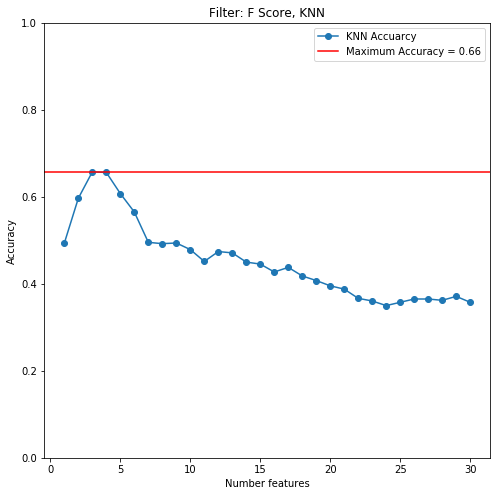

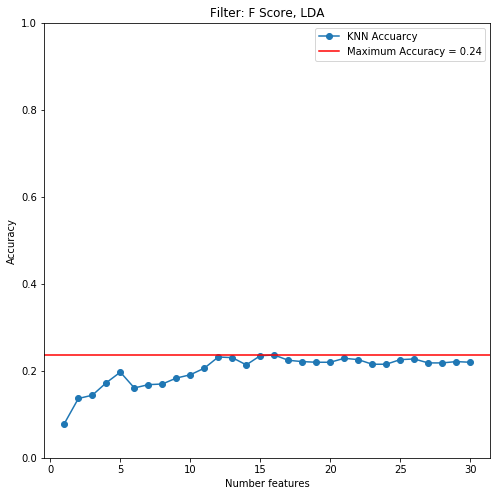

In [4]:
save_figs = False

plt.title("Filter: F Score, KNN")
ax = plt.plot(range(1,nr_features+1), f_scores_filtered_knn, marker='o')
plt.ylim((0, 1))
plt.xlabel("Number features")
plt.ylabel("Accuracy")

plt.axhline(y=max(f_scores_filtered_knn), c='r')
labels = ["KNN Accuarcy", "Maximum Accuracy = {:0.2f}".format(max(f_scores_filtered_knn))]
plt.legend(labels = labels)
if save_figs:
    plt.savefig("fscore-knn", dpi=300,
            orientation='portrait',
            transparent=False, bbox_inches=None, pad_inches=0.1)
    

plt.show()

plt.title("Filter: F Score, LDA")
plt.plot(range(1,nr_features+1), f_scores_filtered_lda, marker='o')
plt.ylim((0, 1))
plt.xlabel("Number features")
plt.ylabel("Accuracy")
plt.axhline(y=max(f_scores_filtered_lda),  c='r')
labels = ["KNN Accuarcy", "Maximum Accuracy = {:0.2f}".format(max(f_scores_filtered_lda))]
plt.legend(labels = labels)
if save_figs:
    plt.savefig("fscore-lda", dpi=300,
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1)

plt.show()

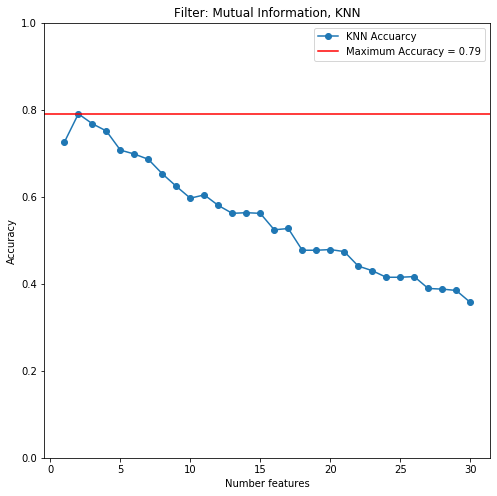

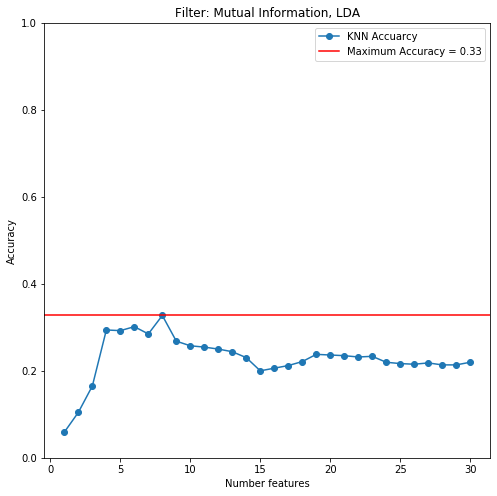

In [5]:
save_figs = False

plt.title("Filter: Mutual Information, KNN")
ax = plt.plot(range(1,nr_features+1), mi_scores_filtered_knn, marker='o')
plt.ylim((0, 1))
plt.xlabel("Number features")
plt.ylabel("Accuracy")

plt.axhline(y=max(mi_scores_filtered_knn), c='r')
labels = ["KNN Accuarcy", "Maximum Accuracy = {:0.2f}".format(max(mi_scores_filtered_knn))]
plt.legend(labels = labels)
if save_figs:
    plt.savefig("mi-knn", dpi=300,
            orientation='portrait',
            transparent=False, bbox_inches=None, pad_inches=0.1)
    

plt.show()

plt.title("Filter: Mutual Information, LDA")
plt.plot(range(1,nr_features+1), mi_scores_filtered_lda, marker='o')
plt.ylim((0, 1))
plt.xlabel("Number features")
plt.ylabel("Accuracy")
plt.axhline(y=max(mi_scores_filtered_lda),  c='r')
labels = ["KNN Accuarcy", "Maximum Accuracy = {:0.2f}".format(max(mi_scores_filtered_lda))]
plt.legend(labels = labels)
if save_figs:
    plt.savefig("fscore-lda", dpi=300,
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1)

plt.show()

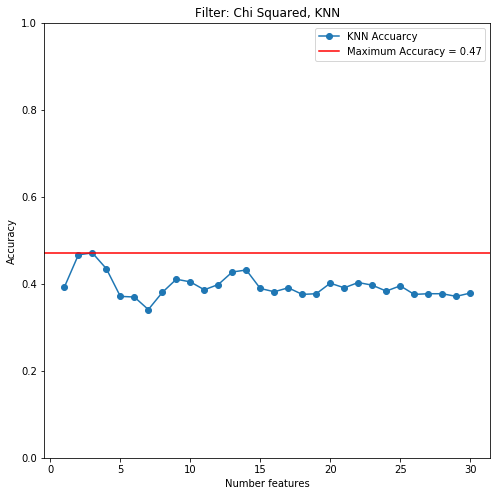

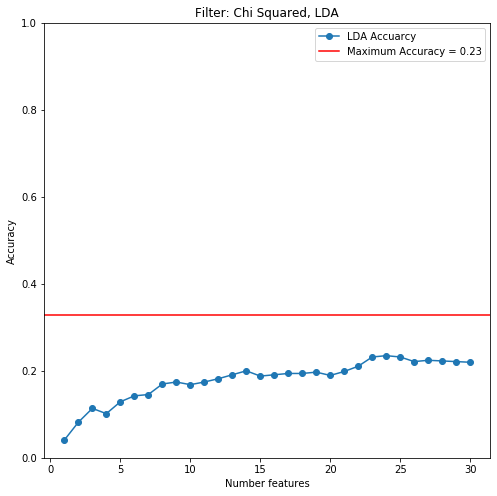

In [6]:
save_figs = False

plt.title("Filter: Chi Squared, KNN")
ax = plt.plot(range(1,nr_features+1), chi2_scores_filtered_knn, marker='o')
plt.ylim((0, 1))
plt.xlabel("Number features")
plt.ylabel("Accuracy")

plt.axhline(y=max(chi2_scores_filtered_knn), c='r')
labels = ["KNN Accuarcy", "Maximum Accuracy = {:0.2f}".format(max(chi2_scores_filtered_knn))]
plt.legend(labels = labels)
if save_figs:
    plt.savefig("mi-knn", dpi=300,
            orientation='portrait',
            transparent=False, bbox_inches=None, pad_inches=0.1)
    

plt.show()

plt.title("Filter: Chi Squared, LDA")
plt.plot(range(1,nr_features+1), chi2_scores_filtered_lda, marker='o')
plt.ylim((0, 1))
plt.xlabel("Number features")
plt.ylabel("Accuracy")
plt.axhline(y=max(mi_scores_filtered_lda),  c='r')
labels = ["LDA Accuarcy", "Maximum Accuracy = {:0.2f}".format(max(chi2_scores_filtered_lda))]
plt.legend(labels = labels)
if save_figs:
    plt.savefig("fscore-lda", dpi=300,
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1)

plt.show()

## Filter & Wrapping Evaluation

In [32]:
nr_features=15
nr_classes= np.array([5,10,15,20,25,30,35,40,45,50])
nr_points = 500
variance_size = 8


# Filters
f_score_accs = np.zeros(len(nr_classes))
mi_accs = np.zeros(len(nr_classes))
chi2_accs = np.zeros(len(nr_classes))
vt_accs = np.zeros(len(nr_classes))
orig_accs = np.zeros(len(nr_classes))

f_score_times =  np.zeros(len(nr_classes))
mi_times = np.zeros(len(nr_classes))
chi2_times = np.zeros(len(nr_classes))
vt_times = np.zeros(len(nr_classes))
orig_times = np.zeros(len(nr_classes))

# Wrapping Methods
sfs_accs = np.zeros(len(nr_classes))
sbs_accs = np.zeros(len(nr_classes))
rfe_accs = np.zeros(len(nr_classes))

sfs_times = np.zeros(len(nr_classes))
sbs_times = np.zeros(len(nr_classes))
rfe_times = np.zeros(len(nr_classes))


for i,nc in enumerate(nr_classes):
    
    X,y = gd.gaussian_clusters(nr_features, nr_classes=nc, \
                           nr_data_points=nr_points, random_diag=True, variance_size=variance_size)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    orig_time, orig_acc = orig_class(X_train, X_test, y_train, y_test, class_alg=LinearDiscriminantAnalysis())
    
    print("========= Num Classes {} ==========".format(nc))
    
    
    # =============== Filters ===============
    best_ks, best_scores, times, f_scores_filtered_knn, f_scores_filtered_lda, mi_scores_filtered_knn, \
    mi_scores_filtered_lda, chi2_scores_filtered_knn, \
    chi2_scores_filtered_lda = run_filters(X_train, y_train, X_test, y_test, only_lda=True)
    vt_time, vt_acc, vt_num_feat = vt_feat_sel(X_train, X_test, y_train, y_test)
    
    # Accuracy
    f_score_accs[i] = np.max(f_scores_filtered_lda)
    mi_accs[i] = np.max(mi_scores_filtered_lda)
    chi2_accs[i] = np.max(chi2_scores_filtered_lda)
    vt_accs[i] = np.max(vt_acc)
    orig_accs[i] = orig_acc
    
    #  Times
    f_score_times[i] = times[3]
    mi_times[i] = times[4]
    chi2_times[i] = times[5]
    orig_times[i] = orig_time
    vt_times[i] = vt_time
    
    # =============== Wrapping ===============
    sfs_time, sfs_acc, rfe_selected_features = seq_feat_sel(X_train, X_test, y_train, y_test, num_feat=10, forward_sfs=True)
    sbs_time, sbs_acc, sbs_selected_features = seq_feat_sel(X_train, X_test, y_train, y_test, num_feat=10, forward_sfs=False)
    rfe_time, rfe_acc, rfe_selected_features = rfe_feat_sel(X_train, X_test, y_train, y_test)
    
    # Accuracy
    sfs_accs[i] = sfs_acc
    sbs_accs[i] = sbs_acc
    rfe_accs[i] = rfe_acc
    orig_accs[i] = orig_acc
    
    # Times
    sfs_times[i] = sfs_time
    sbs_times[i] = sbs_time
    rfe_times[i] = rfe_time
    orig_times[i] = orig_time
    
    

========= Num Classes 5 ==========
========= Num Classes 10 ==========
========= Num Classes 15 ==========
========= Num Classes 20 ==========
========= Num Classes 25 ==========
========= Num Classes 30 ==========
========= Num Classes 35 ==========
========= Num Classes 40 ==========
========= Num Classes 45 ==========
========= Num Classes 50 ==========


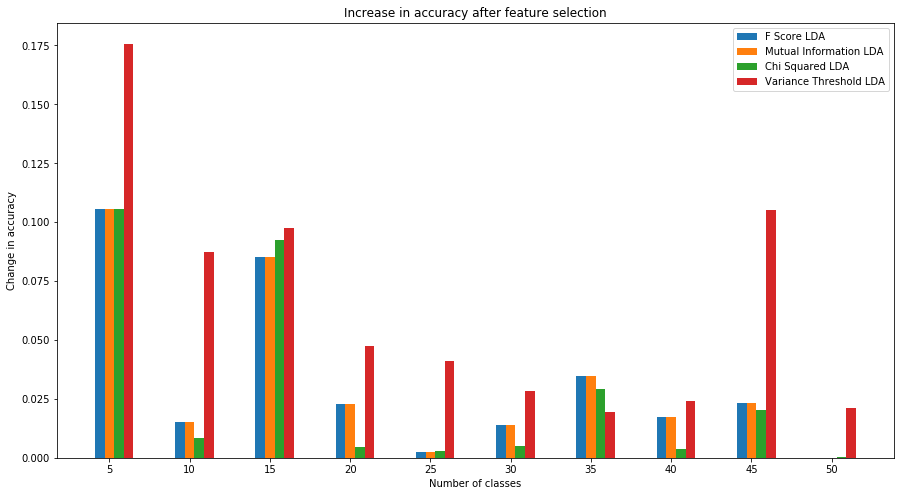

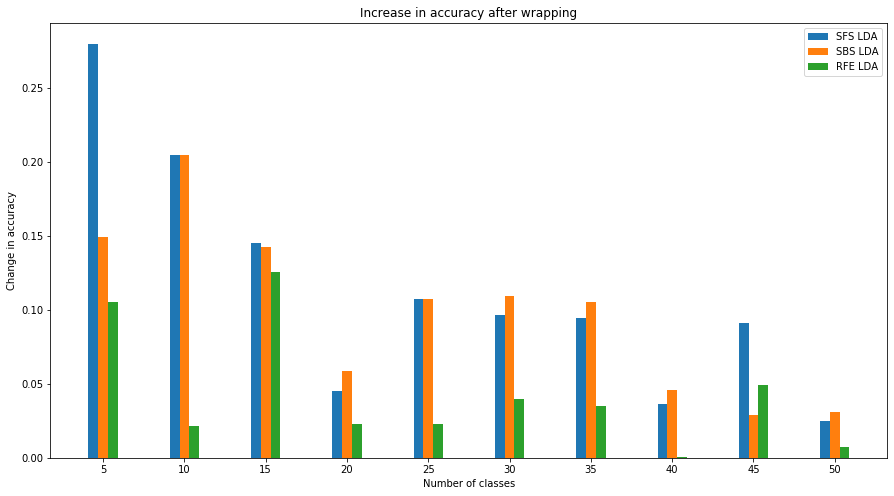

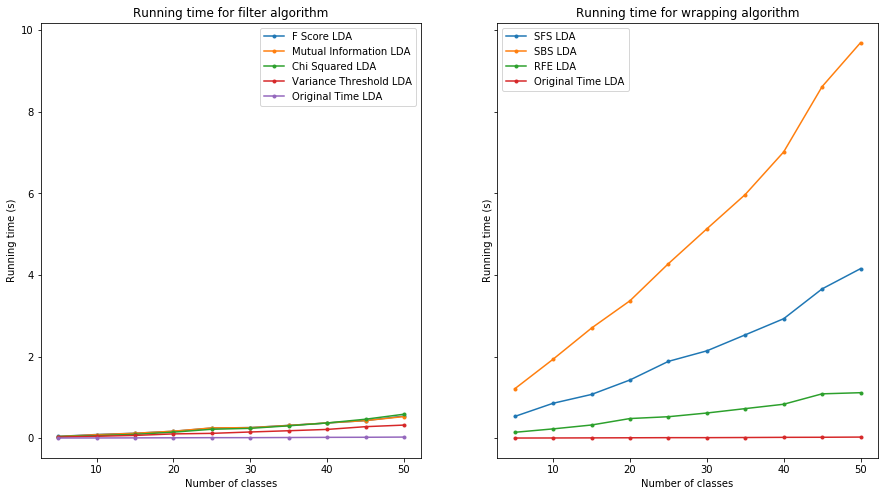

In [43]:
# ================== Accuracy ==================
plt.figure(figsize=(15,8))
bw = 0.6
plt.title("Increase in accuracy after feature selection")
plt.bar(nr_classes-bw, f_score_accs-orig_accs, label="F Score LDA", width=bw, align='center')
plt.bar(nr_classes, mi_accs-orig_accs,  label="Mutual Information LDA",width=bw)
plt.bar(nr_classes+bw, chi2_accs-orig_accs,  label="Chi Squared LDA",width=bw)
plt.bar(nr_classes+bw*2, vt_accs-orig_accs,  label="Variance Threshold LDA",width=bw)
plt.legend()
plt.xlabel('Number of classes')
plt.ylabel('Change in accuracy')
plt.xticks(nr_classes)
plt.show()

plt.figure(figsize=(15,8))
plt.title("Increase in accuracy after wrapping")
plt.bar(nr_classes-bw, sfs_accs-orig_accs, label="SFS LDA", width=bw, align='center')
plt.bar(nr_classes, sbs_accs-orig_accs,  label="SBS LDA",width=bw)
plt.bar(nr_classes+bw, rfe_accs-orig_accs,  label="RFE LDA",width=bw)
plt.legend()
plt.xlabel("Number of classes")
plt.ylabel("Change in accuracy")
plt.xticks(nr_classes)
plt.show()


# ================== Running Time ==================

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,8))

f.figsize = (15,8)

ax1.set_title("Running time for filter algorithm")
ax1.plot(nr_classes, f_score_times, marker='.', label="F Score LDA")
ax1.plot(nr_classes, mi_times, marker='.', label="Mutual Information LDA")
ax1.plot(nr_classes, chi2_times, marker='.', label="Chi Squared LDA")
ax1.plot(nr_classes, vt_times, marker='.', label="Variance Threshold LDA")
ax1.plot(nr_classes, orig_times, marker='.', label="Original Time LDA")
ax1.set_xlabel('Number of classes')
ax1.set_ylabel('Running time (s)')
ax1.legend()

ax2.set_title("Running time for wrapping algorithm")
ax2.plot(nr_classes, sfs_times, marker='.', label="SFS LDA")
ax2.plot(nr_classes, sbs_times, marker='.', label="SBS LDA")
ax2.plot(nr_classes, rfe_times, marker='.', label="RFE LDA")
ax2.plot(nr_classes, orig_times, marker='.', label="Original Time LDA")
ax2.set_xlabel("Number of classes")
ax2.set_ylabel("Running time (s)")
ax2.legend()

plt.show()